## Solutions to Markov Chain Monte Carlo for the Ising Model 
Recall that the Hamiltonian for the Ising Model on a $L \times L$ lattice is given by:
$$ H = -J \sum_{\langle ij \rangle} \sigma_i \sigma_j$$
where $\sigma_{i} = \pm 1$ and $J>0$ is a ferromagnetic coupling. 

The main goal of this problem is to see if by using Markov Chain Monte Carlo for the Ising Model can we detect the presence of a phase transition in a finite system?

Onsager found that the critical temperature of the phase transiton is given by $T_{c} \approx 2.27$. This is relevent since we should expect to see a divergence in the heat capacity here, something that can be calculated directly from the Monte Carlo simulations. 

### (i) Setup up a Class for the Ising Model 


In [292]:
import numpy as np
import numpy.random as rnd

class Configuration(object):
    
    """
    
        Generates an Ising Configuration given by T, J and L
    
    """

    def __init__(self, T, J, L):
        self.size = L
        self.J = J
        self.beta = 1./T
        self.spins = rnd.choice([-1,1], size=(L,L))      # random numbers either -1 or +1
        self.energy = self._get_energy()
        self.magnetization = self._get_magnetization()
        
    def _get_energy(self):
        
        """
            Total energy of a configuration
        
        """
        
        energy = 0.
        #for i,j in itertools.product(range(self.size), repeat=2):
        for i in range(self.size):
            for j in range(self.size):
                energy += (self.spins[i,j])*((self.spins[i,(j+1)%self.size] + self.spins[(i+1)%self.size,j] + \
                           self.spins[i,(j-1)%self.size] + self.spins[(i-1)%self.size,j]))
        energy = -energy*(self.J) 
        return energy
    
    
    
    def _get_magnetization(self):
        
        """
            Total Magnetisation of a configuration
                
        """
        
        magnetism = np.sum(self.spins)
        return magnetism        
    
    
    
def config_to_image(config):
    """
    
        Array -> Image
    
    """
    
    L = config.size
    im = np.zeros([L,L,3])
    for i in range(L):
        for j in range(L):
            im[i,j,:] = (1,2,3) if config.spins[i,j]==1 else (0,0,0)
    return im

To perform a sanity check, it is useful to make sure that configurations are being generated sensibly. Using imshow mehthod belonging to matplotlib allows this to be achieved. The utility of the class is clearly illustrated 

Total magnetisation of configuration is =  -6  Total enegery of configuration is =  -8.0


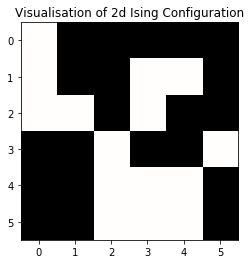

In [246]:
%matplotlib inline
import matplotlib.pyplot as plt

# Show the random configuration
config = Configuration(4, 1.0, 6)
#print(config_to_image(config))
plt.imshow(config_to_image(config)) # uses imshow method from matplotlib to visualise the configuration
plt.title("Visualisation of 2d Ising Configuration")
print "Total magnetisation of configuration is = ", config.magnetization, " Total enegery of configuration is = ", config.energy

### (ii) The Metropolis Move 
In the code below we write a function that takes a configuration and does a single metropolis move on it. This amounts to choosing a random sping, then flipping it and finally checking if the spin satisfies the Metropolis criteria in order to change the configuration.

In [262]:
def metropolis_move(config):
    """
    Change configuration according to metropolis
    
    """
    
    L = config.size
    J = config.J
    beta = config.beta
    i, j = rnd.randint(L, size=(2)) # this picks a random site to flip 
    
     
    # energy difference
    coef = 2*J*config.spins[i,j]
    delta_energy = coef * (config.spins[i,(j+1)%L] + config.spins[(i+1)%L,j] + \
                           config.spins[i,(j-1)%L] + config.spins[(i-1)%L,j])
    
    accept_bool = "No"
    
    # Metroplis acceptance criteria for configuration change
    if rnd.random() < np.exp(-beta*delta_energy):
        accept_bool = "Yes"
        config.spins[i,j] *= -1
        config.energy += delta_energy
        config.magnetization += 2*config.spins[i,j]
        
        
    #print "The chosen site to flip is:" ,i, j 
    #print "Is the flip accepted? ", accept_bool


To check if the alogrithm is working, the print statements can be uncommented in metropolis_move() and the below code prints out if there has been a flip and a comparison between the old and new configurations can be made.

The chosen site to flip is: 2 5
Is the flip accepted?  Yes


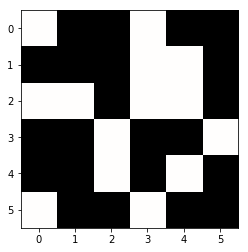

In [261]:
plt.imshow(config_to_image(config), interpolation='none') # old configuration
metropolis_move(config)

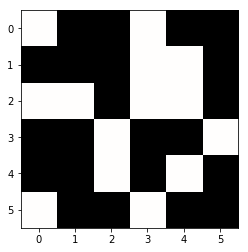

In [260]:
plt.imshow(config_to_image(config), interpolation='none') # new configuration 

### (iii) Physical Observables
To understand the physics of the problem it is necessary to perform some more quantitative measurements, especially those that can be derived from the energy and magnetisation of the system. Effectively, this amounts to taking averages. Since successive configurations only differ by a spin-flip, the correlation between them is non-trivial and can be taken into account by only measuring quantities over cycles to ensure that the succssive configurations become decorrelated. Moreover, it is also important to let the Markov Chain reach it's stationary distribution implying that there should be a "warm-up" period where quantities that are to be measured are not averaged over during this time. 

Therefore, we need to introduce the following variables to control the calculations of avergages

- length_cycle: the number of steps between two measurements to make sure we aren't sampling correlated configurations.
- n_cyles: the total number of measuremants.
- n_warmup: the initial number of cycles where no measurements are taken because the Markov chain hasn't reached a stationary distribution yet.

As a simple example, the average magnetisation of the system can be calculated as:

(-1, 1)

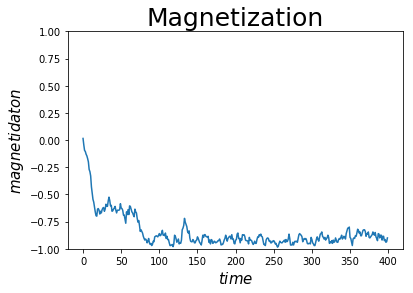

In [289]:
%matplotlib inline

L = 20
T = 2.0

n_warmup = 100 # number of warmup steps
n_cycles = 500 # number of measurements of the magnetisation 
length_cycle = L**2 # number of metropolis moves in each cycle

config = Configuration(T, 1.0, L) # starting configuration 

mag = np.zeros(n_cycles-n_warmup)

# Monte Carlo
for n in range(n_cycles):
    for k in range(length_cycle):
        metropolis_move(config)
    if(n >= n_warmup):
        mag[n-n_warmup] = config.magnetization
mag /= float(L**2)
        
plt.plot(mag, '-')
plt.title("Magnetization", fontsize=25)
plt.xlabel("$time$", fontsize=15)
plt.ylabel("$magnetidaton$", fontsize=15)
plt.ylim(-1,1)

### (iv) Full Monte Carlo simulation 
The final step that needs be accomplished is to run a large scale Monte Carlo simulation for this model. This amounts to calculating the ground state observables at different temperatures. If there is a phase transition, there should be a signtaure of it in the observables. 

This step primarily amounts to ensuring that the inner loops of the Monte Carlo simulation are nested in the correct way. Making sure this is correct, the simulation effectively boils down to calculating averages. 

A good programming practice is to split code into production and post-production stages. All this means is that one part of the code will do all of the heavy lifting and dump all of that information into files. The files will then be read into. This way of programming allows you to only run a simulation once and to do all of the analysis on the data afterwards, instead of doing it in-situ with raw calculations. 

In [290]:
# create a temperature range 
temp_range = np.hstack([np.arange(0.5,2.,0.5), np.arange(2.,2.5,0.05), np.arange(2.5,5,0.5)])

# initialise observable arrays 
mag = np.zeros_like(temp_range)
energ = np.zeros_like(temp_range)
chi = np.zeros_like(temp_range) # susceptibilty 
cv = np.zeros_like(temp_range) # heat capacity 

# lattice size
L = 4

for i,T in enumerate(temp_range):

    config = Configuration(T, 1.0, L)
    
    av_m, av_m2, av_e, av_e2 = 0,0,0,0

    n_cycles = 10000
    length_cycle = L*L
    n_warmup = 1000

    # Monte Carlo
    for n in range(n_warmup+n_cycles):
        
        for k in range(length_cycle):
            metropolis_move(config)
        
        if (n >= n_warmup):
            av_e  += config.energy
            av_e2 += config.energy**2
            av_m  += config.magnetization
            av_m2 += config.magnetization**2
            
    # normalise avergaes with respect to number of cycles
    av_m  /= float(n_cycles)
    av_m2 /= float(n_cycles)
    av_e  /= float(n_cycles)
    av_e2 /= float(n_cycles)
            
    # average over the lattice
    fact = 1./L**2
    mag[i] = fact * av_m
    energ[i] = fact * av_e
    cv[i] = fact * (av_e2 - av_e**2) / T**2 # heat capacity 
    chi[i] = fact * (av_m2 - av_m**2) / T # susceptabilty
    
    # printing progress
    print "T = %f and %.2f percent done"%(T, (100.*(i+1))/len(temp_range))


# save the arrays into a file 
np.savetxt("energ_%i.dat"%L, energ)
np.savetxt("mag_%i.dat"%L, mag)
np.savetxt("cv_%i.dat"%L, cv)
np.savetxt("chi_%i.dat"%L, chi)

T = 0.500000 and 5.56 percent done
T = 1.000000 and 11.11 percent done
T = 1.500000 and 16.67 percent done
T = 2.000000 and 22.22 percent done
T = 2.050000 and 27.78 percent done
T = 2.100000 and 33.33 percent done
T = 2.150000 and 38.89 percent done
T = 2.200000 and 44.44 percent done
T = 2.250000 and 50.00 percent done
T = 2.300000 and 55.56 percent done
T = 2.350000 and 61.11 percent done
T = 2.400000 and 66.67 percent done
T = 2.450000 and 72.22 percent done
T = 2.500000 and 77.78 percent done
T = 3.000000 and 83.33 percent done
T = 3.500000 and 88.89 percent done
T = 4.000000 and 94.44 percent done
T = 4.500000 and 100.00 percent done


Finally, we can plot the results from the data files:

(0, 2)

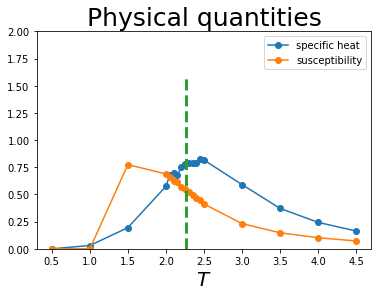

In [247]:
%matplotlib inline
import matplotlib.pyplot as plt

L = 4
Tc = 2./(np.log(1+np.sqrt(2)))

energ = np.loadtxt("energ_%i.dat"%L)
mag = np.loadtxt("mag_%i.dat"%L)
cv = np.loadtxt("cv_%i.dat"%L)
chi = np.loadtxt("chi_%i.dat"%L)

#plt.plot(temp_range, np.loadtxt("energ_%i.dat"%L)+2, '-o', label="energy")
#plt.plot(temp_range, np.abs(np.loadtxt("mag_%i.dat"%L)), '-o', label="magnetization")
plt.plot(temp_range, np.loadtxt("cv_%i.dat"%L), '-o', label="specific heat")
plt.plot(temp_range, np.loadtxt("chi_%i.dat"%L)/10, '-o', label="susceptibility")

plt.plot([Tc,Tc], [0,1.6], '--', lw=3)
plt.legend()
plt.title("Physical quantities", fontsize=25)
plt.xlabel("$T$", fontsize=20)
plt.ylim(0,2)

If we take the case of the of specific heat capacity, there is an indication of a divergence at the transition temperature, which is indicative of a phase transition.


An interesting study is to explore different values of $L$ and see if this divergence becomes more dramatic at the transition temperature, demonstrating that we can see artifacts of the phase transition in a finite system and justifying the use of the Monte Carlo method. 